# Universal antagonism classification for a few cell lines
Generate model curves for different surface molecule numbers corresponding to different cell lines. We use EC50s consistently based on our CD25 dose response curves for the purpose of comparing these cell lines in this notebook. From these curves, for any antigen cognate to some TCR given its EC$_{50}$, we can predict whether it will be an agonist or antagonist at a given dose, against some other dose of CAR antigen. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, h5py
import os
import sys
if not "../" in sys.path:
    sys.path.insert(1, "../")

In [2]:
from utils.preprocess import michaelis_menten, geo_mean_apply
from models.conversion import convert_ec50_tau_relative
from mcmc.plotting import change_log_ticks
from utils.preprocess import geo_mean_apply, write_conc_uM
from mcmc.costs_tcr_car_antagonism import antag_ratio_panel_tcr_car
from mcmc.ci_predictions_molec_numbers import confidence_predictions_car_antagonism

In [3]:
# Choose 10 for quick test run, 1000 for adequate statistics
n_boot = 1000
# Change to True to save results and plots
do_save_outputs = False
do_save_plots = False
fig_dir = os.path.join("..", "figures", "extra_predictions")

## Aesthetic parameters

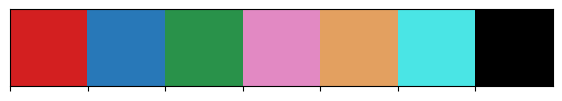

In [4]:
with open(os.path.join("..", "results", "for_plots", "perturbations_palette.json"), "r") as f:
    perturb_palette = json.load(f)
perturb_palette["None"] = [0., 0., 0., 1.]  # Black
sns.palplot(perturb_palette.values())

# EC50 to $\tau$ conversion

In [5]:
# Import CD25-based EC50s, to compute taus across different TCRs (murine, human, etc.)
# In M
df_cd25_ec50s = (pd.read_hdf(os.path.join("..", "data", "dose_response", "experimental_peptide_ec50s_blasts.h5"), 
                key="df").xs("CD25fit", level="Method"))
df_cd25_ec50s = df_cd25_ec50s.groupby(["TCR", "Peptide"]).apply(geo_mean_apply)

# Rename HHAT peptides to HHAT-...
rename_dict = {p:"HHAT-{}".format(p) for p in df_cd25_ec50s.xs("HHAT").index.unique()}
rename_dict.update({p:"NYESO-{}".format(p) for p in df_cd25_ec50s.xs("NYESO").index.unique()})
rename_dict.update({p:"OT1-{}".format(p) for p in df_cd25_ec50s.xs("OT1").index.unique()})
df_cd25_ec50s = df_cd25_ec50s.rename(rename_dict, level="Peptide")

df_cd25_ec50s

TCR    Peptide     
HHAT   HHAT-WT         3.681205e-05
       HHAT-p8F        6.200921e-09
NYESO  NYESO-4A5P8K    4.289705e-04
       NYESO-8K        1.556333e-05
       NYESO-8S        1.005998e-05
       NYESO-9C        4.239615e-06
       NYESO-9V        1.688286e-09
OT1    OT1-A2          1.506925e-10
       OT1-E1          1.000000e-03
       OT1-G4          2.591192e-05
       OT1-N4          3.427715e-11
       OT1-Q4          3.600203e-09
       OT1-T4          9.634081e-09
       OT1-V4          6.841858e-07
Name: ec50_M, dtype: float64

In [6]:
# Choose reference point: N4 at 10 s
ref_file = os.path.join("..", "data", "reference_pep_tau_maps.json")
with open(ref_file, "r") as file:
    tau_refs = json.load(file)

ref_tau_n4 = tau_refs.get("N4")

# Also choose reference absolute EC50 for N4: use CD25 EC50s
# This means we will have different taus for OT-1 peptides vs. fig. 2
# But that's OK, we are using a different set of EC50s
# to illustrate the general procedure to predict antagonism
ref_ec50_n4 = df_cd25_ec50s.at[("OT1", "OT1-N4")]

def ec50_to_tau(ec50: np.float64, ec50_ref=ref_ec50_n4, tau_ref=ref_tau_n4):
    """ 
    Convert an absolute EC50 (in M) to a binding time, 
    with SIINFEKL = 10 s as a reference. 
    """
    return convert_ec50_tau_relative(ec50 / ec50_ref, tau_ref, npow=6)

# Other conversions and parameter loading

## Load model parameters

In [7]:
# Load model best fits
fit_conc = ["1uM", "1nM"]
analysis_res_fname = "mcmc_analysis_tcr_car_both_conc.json"
with open(os.path.join("..", "results", "mcmc", analysis_res_fname), "r") as jfile:
    all_results_dicts = json.load(jfile)
    del jfile

# Go back to linear-scale parameters
chosen_kmf = (1, 2, 1)
pvec_best = np.asarray(all_results_dicts.get(str(chosen_kmf)).get("param_estimates").get("MAP best"))

## Pulse concentration to antigen number conversion
Assuming the peptides load correctly on tumor cells. 

In other words, loading EC50 of the peptide is the same as for OT1 peptides. Obviously, this is not always true.  

In [8]:
# Load constant parameter values
samples_fname = samples_fname = "mcmc_results_tcr_car_both_conc.h5"
with h5py.File(os.path.join("..", "results", "mcmc", samples_fname), "r") as rfile:
    data_group = rfile.get("data")
    # Load samples too, for CI generation
    mcmc_samples_car = rfile.get("samples").get(str(chosen_kmf))[()]
    fit_param_names = list(rfile.get("samples").attrs.get("param_names"))
    l_conc_mm_params = data_group.get("l_conc_mm_params")[()]
    cost_args_loaded = [data_group.get(a)[()]
                        for a in data_group.attrs.get("cost_args_names")]
    del data_group, rfile

In [9]:
# Multiply this by the number of MHC per tumor cell
def pulse_to_frac_loaded(conc):
    """ Compute the fraction of MHC that will be loaded at a pulse conc (in uM)"""
    return michaelis_menten(conc, 1.0, l_conc_mm_params[1])

## Load surface molecule numbers

In [10]:
# Load all CAR and TCR antigen numbers on the tumor lines used for each TCR line
molec_counts_filename = "../data/surface_counts/surface_molecule_summary_stats.h5"
mtc = "Geometric mean"
tumors = ["E2APBX", "Nalm6", "PC9", "BEAS2B"]

# Maping each TCR line to a tumor type
# Let HHAT peptides both be on PC9, the tumor line
# As a proxy for MSKCC data, K562 (which we havent' characterized) is most similar to Nalm6
tcr_to_tumor = {"OT1":("E2APBX",), "NYESO":("Nalm6",), "HHAT":("BEAS2B", "PC9"), "MSKCC":("Nalm6",)}

# Surface area of cells, relative to E2aPBX
# Unsure about surface area of PC9 and BEAS2B, using 1.0
size_factors = {"E2APBX":1.0, "Nalm6":2.0, "PC9":1.0, "BEAS2B":1.0}

# Prepare DataFrame with MHC and tumor antigen levels
df_carag_mhc = pd.DataFrame(np.zeros([len(tumors), 2]), index=pd.Index(tumors, name="Tumor"), 
                           columns=pd.Index(["MHC", "CAR_Ag"], name="Molecule"))

# E2aPBX
molec_stats = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
df_carag_mhc.loc["E2APBX", "MHC"] = molec_stats.loc[("E2aPBX_WT", "MHC"), mtc] / size_factors["E2APBX"]
df_carag_mhc.loc["E2APBX", "CAR_Ag"] = molec_stats.loc[("E2aPBX_WT", "CD19"), mtc]

# NYESO: on Nalm6
df_carag_mhc.loc["Nalm6", "MHC"] = molec_stats.loc[("Nalm6_19hi", "MHC"), mtc] / size_factors["Nalm6"]
df_carag_mhc.loc["Nalm6", "CAR_Ag"] = molec_stats.at[("Nalm6_19hi", "CD19"), mtc] / size_factors["Nalm6"]

# HHAT: assume both on the tumor line, PC9 (disregard healthy tissue BEAS2B)
for tum in ["PC9", "BEAS2B"]:
    df_carag_mhc.loc[tum, "MHC"] = molec_stats.loc[(tum, "MHC"), mtc] / size_factors[tum]
    df_carag_mhc.loc[tum, "CAR_Ag"] = molec_stats.loc[(tum, "Her2"), mtc] / size_factors[tum]

df_carag_mhc

Molecule,MHC,CAR_Ag
Tumor,,
E2APBX,5.797990e+04,106510.143849
Nalm6,4.069364e+05,231112.433749
PC9,7.377525e+05,33294.225173
BEAS2B,3.007904e+06,17051.265575


# Antagonism as a function of EC50 for various TCR kinds
Continuous model curve vs tau (or EC50?) for each TCR line, with appropriate tumor numbers

In [11]:
dens_name = "TCR_Antigen_Density_uM"

In [12]:
# Generate model curves as a function of tau for each tumor line
# Do 1 uM and 1 nM. Will correspond to different ligand numbers
# since the number of MHC varies per APC line. 
tau_range = np.linspace(tau_refs["None"], tau_refs["N4"], 200)
pulse_concs = [1e0, 1e-3]
cond_index = pd.MultiIndex.from_product(
    [pulse_concs, tau_range], names=[dens_name, "TCR_Antigen_tau"]
).sort_values()
model_curves = {}
n_tumors = len(sum(tuple(a for a in tcr_to_tumor.values()), ()))
seedlist = np.random.SeedSequence(0xe55069716ae615153a71f0cebb4211c6).spawn(n_tumors)
tum_i = 0
for tcr, tumor in tcr_to_tumor.items():
    # For HHAT, different tumor in fact for p8f or WT peptide
    # Else, one tumor type, still need the level in the dataframe
    for tum in tumor:
        tumor_line_info = {
            "l_conc_mm_params":[df_carag_mhc.loc[tum, "MHC"], l_conc_mm_params[1]], 
            "car_ag":df_carag_mhc.loc[tum, "CAR_Ag"]
        }
        # Compute model predictions of antagonism ratio. Not adjusting any parameter
        # since we are making predictions about cytokines. 
        model_curves[(tcr, tum)] = confidence_predictions_car_antagonism(
            antag_ratio_panel_tcr_car, 
            mcmc_samples_car,
            pvec_best,
            chosen_kmf,
            cond_index,
            other_args=cost_args_loaded,
            cell_info=tumor_line_info, 
            n_samp=n_boot, 
            seed=seedlist[tum_i], 
            tcr_pulse_lvl=dens_name
        )
        tum_i += 1
        # Rename ligand numbers to concentrations
        model_curves[(tcr, tum)] = (model_curves[(tcr, tum)]
                             .rename(write_conc_uM, level=dens_name))
        print("Finished tumor line {}".format(tum))
    print("Generated model curves for {} TCR".format(tcr))
    print()


model_curves = pd.concat(model_curves, names=["TCR", "Tumor"])
model_curves.name = "FC"
model_curves

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line E2APBX
Generated model curves for OT1 TCR

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line Nalm6
Generated model curves for NYESO TCR

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line BEAS2B
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line PC9
Generated model curves for HHAT TCR

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 

percentile_2.5    median  \
TCR   Tumor  TCR_Antigen_Density_uM TCR_Antigen_tau                             
OT1   E2APBX 1nM                    0.001000               1.000000  1.000000   
                                    0.051246               0.999971  0.999998   
                                    0.101492               0.999385  0.999957   
                                    0.151739               0.996517  0.999758   
                                    0.201985               0.988541  0.999191   
...                                                             ...       ...   
MSKCC Nalm6  1uM                    9.799015               2.459008  2.685981   
                                    9.849261               2.459203  2.686315   
                                    9.899508               2.459390  2.686638   
                                    9.949754               2.459571  2.686949   
                                    10.000000              2.459746  2.687226   

                                                         mean  geo_mean  \
TCR   Tumor  TCR_Antigen_Density_uM TCR_Antigen_tau                       
OT1   E2APBX 1nM                    0.001000         1.000000  1.000000   
                                    0.051246         0.999994  0.999994   
                                    0.101492         0.999873  0.999873   
                                    0.151739         0.999279  0.999278   
                                    0.201985         0.997609  0.997604   
...                                                       ...       ...   
MSKCC Nalm6  1uM                    9.799015         2.697952  2.694287   
                                    9.849261         2.698291  2.694622   
                                    9.899508         2.698618  2.694945   
                                    9.949754         2.698934  2.695257   
                                    10.000000        2.699238  2.695558   

                                                         best  percentile_97.5  
TCR   Tumor  TCR_Antigen_Density_uM TCR_Antigen_tau                             
OT1   E2APBX 1nM                    0.001000         1.000000         1.000000  
                                    0.051246         0.999999         0.999999  
                                    0.101492         0.999971         0.999983  
                                    0.151739         0.999836         0.999901  
                                    0.201985         0.999451         0.999669  
...                                                       ...              ...  
MSKCC Nalm6  1uM                    9.799015         2.665323         3.005581  
                                    9.849261         2.665595         3.006032  
                                    9.899508         2.665857         3.006467  
                                    9.949754         2.666109         3.006886  
                                    10.000000        2.666353         3.007291  

[2000 rows x 6 columns]

## Predictions for various TCR antigens
For each antigen, predict at 1 $\mu$M and at 1 nM. Then make a bar graph of $\log_2 FC$, with 2 bars for each antigen (black and red). 

In [13]:
def add_pep_names(df, ser_ec50s):
    # Inverse mapping
    pep_names_map = {ser_ec50s.loc[pep]:pep for pep in ser_ec50s.index.get_level_values("Peptide")}
    
    # Create a new column with peptide names and set_index with it
    df["Peptide"] = df.index.get_level_values("TCR_Antigen_tau").map(pep_names_map)
    df = df.set_index("Peptide", append=True, drop=True)
    return df

In [14]:
# Convert the EC50s of all peptides to binding times, based on OT1-N4
# In preparation of the pandas Indexes specifying conditions to predict
tcr_lines_ags_taus = df_cd25_ec50s.apply(ec50_to_tau)
tcr_lines_ags_taus.name = "tau"
pulse_concs = [1e0, 1e-3]  # predict 1 uM and 1 nM
 
n_tumors = len(sum(tuple(a for a in tcr_to_tumor.values()), start=()))
seedlist = np.random.SeedSequence(0x1fc5b69b24110469fe30e2879cdf983f).spawn(n_tumors)
tum_i = 0
model_preds_tcr_ags = {}
for tcr, tumor in tcr_to_tumor.items():
    if tcr == "MSKCC": continue  # Skip this, we don't have CD25 EC50s here
    for tum in tumor:
        # Prepare MultiIndex specifying L, tau 
        cond_index_tumor = pd.MultiIndex.from_product(
            [pulse_concs, tcr_lines_ags_taus.xs(tcr, level="TCR")], 
            names=[dens_name, "TCR_Antigen_tau"]
        ).sort_values()
        # Prepare cell line info
        tumor_line_info = {
            "l_conc_mm_params":[df_carag_mhc.loc[tum, "MHC"], l_conc_mm_params[1]], 
            "car_ag":df_carag_mhc.loc[tum, "CAR_Ag"]
        }
        # Compute CI
        model_preds_tcr_ags[(tcr, tum)] = confidence_predictions_car_antagonism(
                antag_ratio_panel_tcr_car, 
                mcmc_samples_car,
                pvec_best,
                chosen_kmf,
                cond_index_tumor, 
                other_args=cost_args_loaded,
                cell_info=tumor_line_info, 
                n_samp=n_boot, 
                seed=seedlist[tum_i], 
                tcr_pulse_lvl=dens_name
        )
        tum_i += 1  # increment to next tumor, tcr combination
        # Convert pulse concentration to string label
        model_preds_tcr_ags[(tcr, tum)] = (model_preds_tcr_ags[(tcr, tum)]
                .rename(write_conc_uM, level=dens_name))
        # Also add peptide names as an index level
        model_preds_tcr_ags[(tcr, tum)] = add_pep_names(
            model_preds_tcr_ags[(tcr, tum)], tcr_lines_ags_taus.droplevel("TCR"))
        print("Finished tumor line {}".format(tum))
    print("Generated model curves for {} TCR".format(tcr))
    print()

model_preds_tcr_ags = (pd.concat(model_preds_tcr_ags, names=["TCR", "Tumor"])
    .reorder_levels(["TCR", "Tumor", "Peptide", "TCR_Antigen_tau", dens_name])
    .droplevel("TCR_Antigen_tau")
    .sort_index()
)
# Immediately drop the incorrect pairs of HHAT-tumor
model_preds_tcr_ags = model_preds_tcr_ags.drop([("HHAT", "BEAS2B", "HHAT-p8F"), ("HHAT", "PC9", "HHAT-WT")])
# In fact, back to both peptides on PC9, so keep both tumors for both antigens
model_preds_tcr_ags = model_preds_tcr_ags.sort_index()
model_preds_tcr_ags

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line E2APBX
Generated model curves for OT1 TCR

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line Nalm6
Generated model curves for NYESO TCR

Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line BEAS2B
Loaded default TCR number: 121793.30786714314
Loaded default CAR number: 981184.8823272326
Number NaN samples for (1, 2, 1): 0
Finished computing model predictions for (1, 2, 1)
Finished tumor line PC9
Generated model curves for HHAT TCR



percentile_2.5    median  \
TCR   Tumor  Peptide      TCR_Antigen_Density_uM                             
HHAT  BEAS2B HHAT-WT      1nM                           0.084217  0.094733   
                          1uM                           0.090107  0.103323   
      PC9    HHAT-p8F     1nM                           2.473990  3.269915   
                          1uM                           4.955220  6.301389   
NYESO Nalm6  NYESO-4A5P8K 1nM                           0.796973  0.913501   
                          1uM                           0.699586  0.750148   
             NYESO-8K     1nM                           0.757914  0.792408   
                          1uM                           0.667220  0.738502   
             NYESO-8S     1nM                           0.752622  0.783090   
                          1uM                           0.666786  0.738875   
             NYESO-9C     1nM                           0.733325  0.767284   
                          1uM                           0.668295  0.741094   
             NYESO-9V     1nM                           1.245640  1.388429   
                          1uM                           2.110681  2.278927   
OT1   E2APBX OT1-A2       1nM                           2.585153  2.935565   
                          1uM                           3.436711  4.166513   
             OT1-E1       1nM                           0.704016  0.951412   
                          1uM                           0.467809  0.499014   
             OT1-G4       1nM                           0.523015  0.734480   
                          1uM                           0.380965  0.449213   
             OT1-N4       1nM                           3.208206  3.820546   
                          1uM                           3.526010  4.339896   
             OT1-Q4       1nM                           0.665724  0.731262   
                          1uM                           1.868890  2.306647   
             OT1-T4       1nM                           0.491021  0.549300   
                          1uM                           1.221550  1.545682   
             OT1-V4       1nM                           0.476680  0.513739   
                          1uM                           0.421675  0.489630   

                                                      mean  geo_mean  \
TCR   Tumor  Peptide      TCR_Antigen_Density_uM                       
HHAT  BEAS2B HHAT-WT      1nM                     0.096721  0.095764   
                          1uM                     0.104844  0.103860   
      PC9    HHAT-p8F     1nM                     3.281304  3.253938   
                          1uM                     6.301728  6.261969   
NYESO Nalm6  NYESO-4A5P8K 1nM                     0.893005  0.891548   
                          1uM                     0.750567  0.750082   
             NYESO-8K     1nM                     0.793214  0.792962   
                          1uM                     0.737477  0.736586   
             NYESO-8S     1nM                     0.783439  0.783233   
                          1uM                     0.737699  0.736796   
             NYESO-9C     1nM                     0.767793  0.767553   
                          1uM                     0.739925  0.739024   
             NYESO-9V     1nM                     1.385191  1.383579   
                          1uM                     2.279499  2.277197   
OT1   E2APBX OT1-A2       1nM                     2.932124  2.924979   
                          1uM                     4.177875  4.154407   
             OT1-E1       1nM                     0.905148  0.900686   
                          1uM                     0.500383  0.499907   
             OT1-G4       1nM                     0.701732  0.693260   
                          1uM                     0.450987  0.449227   
             OT1-N4       1nM                     3.819511  3.802837   
                          1uM                     4.3

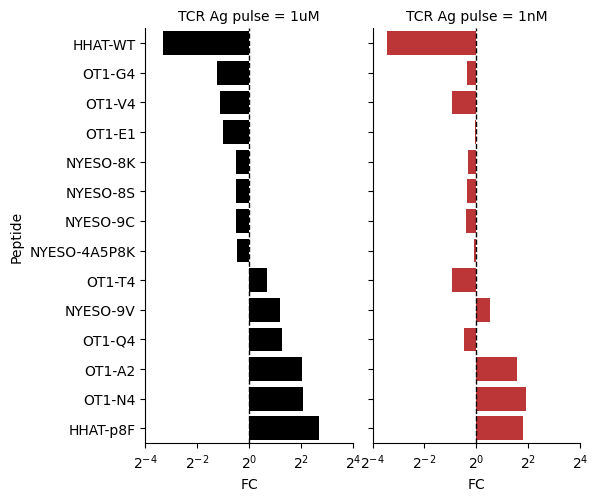

In [16]:
# Plotting the results
agdens_palette = {"1uM": perturb_palette["None"], "1nM": perturb_palette["AgDens"]}
nice_pulse_name = "TCR Ag pulse"
plotDf = np.log2(model_preds_tcr_ags["best"]).to_frame()
plotDf["FC"] = plotDf["best"]
plotDf = plotDf.drop("best", axis=1)
# Sort peptides according to 1 uM antagonism
sorted_peps = (plotDf.xs("1uM", level=dens_name)
               .sort_values(by="FC").index.get_level_values("Peptide"))
# Sort by antigen tau or EC50 instead?
#sorted_peps = sorted(plotDf.index.get_level_values("Peptide").unique(), 
#                    key=lambda x: tcr_lines_ags_taus.loc[(x.split("-")[0], x)])
plotDf.index = plotDf.index.rename(names=nice_pulse_name, level=dens_name)
facet = sns.FacetGrid(
    data=plotDf.reset_index(), 
    hue=nice_pulse_name, 
    palette=agdens_palette, 
    hue_order=["1uM", "1nM"],
    col=nice_pulse_name, 
    col_order=["1uM", "1nM"],
)
facet.map(sns.barplot, "FC", "Peptide", 
         order=sorted_peps)
for ax in facet.axes.flat:
    ax.axvline(0.0, ls="--", color="k", lw=1.0)
facet.figure.set_size_inches(facet.fig.get_size_inches()[0], facet.fig.get_size_inches()[1]*2)
change_log_ticks(facet.axes.flat[0], which="x")
change_log_ticks(facet.axes.flat[1], which="x")
if do_save_plots:
    facet.figure.savefig(os.path.join(fig_dir, "tcr_kinds_antagonism_barplots.pdf"), 
        transparent=True, bbox_inches="tight"
    )
plt.show()
plt.close()

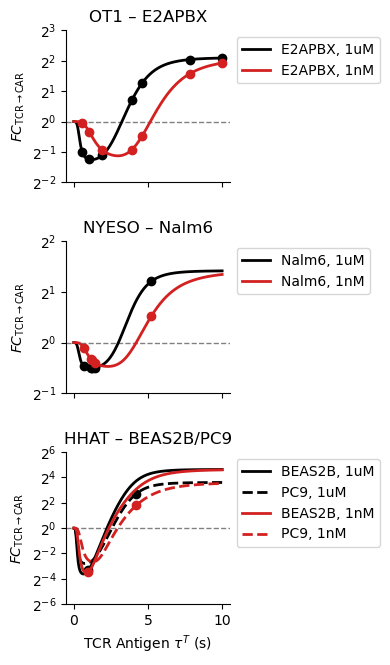

In [17]:
# Plot the model curves
fig, axes = plt.subplots(3, 1, sharex=True)
axes = axes.flatten()
fig.set_size_inches(2.5 + 1.5, 2.25*3)

for i, tcr in enumerate(["OT1", "NYESO", "HHAT"]):
    axes[i].axhline(0.0, ls="--", color="grey", lw=1.0)
    # Plot the model curve
    for ag_dens in model_curves.index.get_level_values(dens_name).unique()[::-1]:
        tum_vals = (model_curves.loc[(tcr, slice(None), ag_dens)].index
                    .remove_unused_levels().get_level_values("Tumor").unique().values)
        lstyles = ["-", "--"]
        for j, tum in enumerate(tum_vals):
            curve = model_curves.loc[(tcr, tum, ag_dens, tau_range), "best"].values
            clr = perturb_palette["None"] if ag_dens == "1uM" else perturb_palette["AgDens"]
            axes[i].plot(tau_range, np.log2(curve), label=", ".join([tum, ag_dens]), 
                         color=clr, lw=2.0, ls=lstyles[j])
            # Mark the experimental antigens on these curves
            peps = (model_preds_tcr_ags.loc[(tcr, tum), "best"].index
                    .get_level_values("Peptide").unique())
            for pep in peps:
                tau = tcr_lines_ags_taus.loc[(tcr, pep)]
                y = np.log2(model_preds_tcr_ags.loc[(tcr, tum, pep, ag_dens), "best"])
                axes[i].plot(tau, y, ls="none", ms=6, marker="o", mfc=clr, mec=clr)
    # Label this plot
    axes[i].set(ylabel=r"$FC_{\mathrm{TCR \rightarrow CAR}}$")
    change_log_ticks(axes[i], base=2, which="y")
    axes[i].set_title(tcr + " – " + "/".join(tcr_to_tumor.get(tcr)))
    axes[i].legend(loc="upper left", bbox_to_anchor=(1, 1))
    for side in ["top", "right"]:
        axes[i].spines[side].set_visible(False)
    
axes[-1].set_xlabel(r"TCR Antigen $\tau^T$ (s)")

fig.tight_layout(h_pad=2.0)
if do_save_plots:
    fig.savefig(os.path.join(fig_dir, "tcr_kinds_model_antagonism_curves.pdf"), 
                      transparent=True, bbox_inches="tight")
plt.show()
plt.close()

In [19]:
# Save the model curves, the extra peptide predictions, and the EC50s and taus of peptides
plot_data_filename = "../results/for_plots/tcr_kinds_universal_antagonism_model.h5"

if do_save_outputs:
    model_curves.to_hdf(plot_data_filename, key="model_curves")
    model_preds_tcr_ags.to_hdf(plot_data_filename, key="model_predictions_tcr_ags")
    tcr_lines_ags_taus.to_hdf(plot_data_filename, key="tcr_lines_antigen_taus")